Name: Emin Eren SARI

ID: 191104087

Course: BIL570 /BIL470

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA



from itertools import cycle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import gzip
import pickle
import shutil

from logreg import LogisticRegression

# Veri Setinin Yüklenmesi:

Aşağıdaki adreslerden .gz uzantılı veri seti yüklenmiştir.
https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz

In [3]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def save_mnist():
    with gzip.open("train-images-idx3-ubyte.gz",'rb') as f_in:
        with open("train-images.idx3-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("t10k-images-idx3-ubyte.gz",'rb') as f_in:
        with open("t10k-images.idx3-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("train-labels-idx1-ubyte.gz",'rb') as f_in:
        with open("train-labels.idx1-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    with gzip.open("t10k-labels-idx1-ubyte.gz",'rb') as f_in:
        with open("t10k-labels.idx1-ubyte",'wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
            
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"];

def load_list():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"].tolist(), mnist["training_labels"].tolist(), mnist["test_images"].tolist(), mnist["test_labels"].tolist()
init();

Save complete.


# Veri Yükleme

In [4]:
X_train, y_train, X_test, y_test = load()



# Exploratory Data Analysis (EDA)

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
             0        1        2        3        4        5        6        7  \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             8        9  ...           775           776           777  \
count  60000.0  60000.0  ...  60000.000000  60000.000000  60000.000000   
mean       0.0      

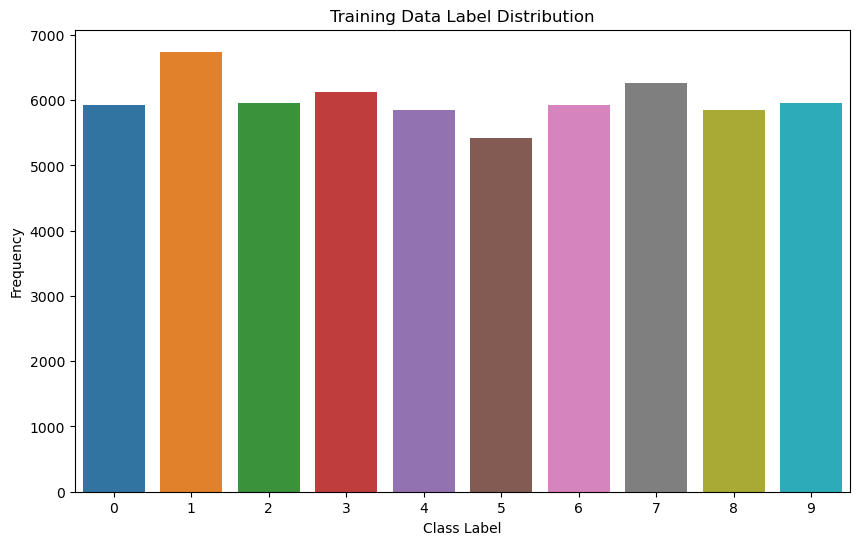

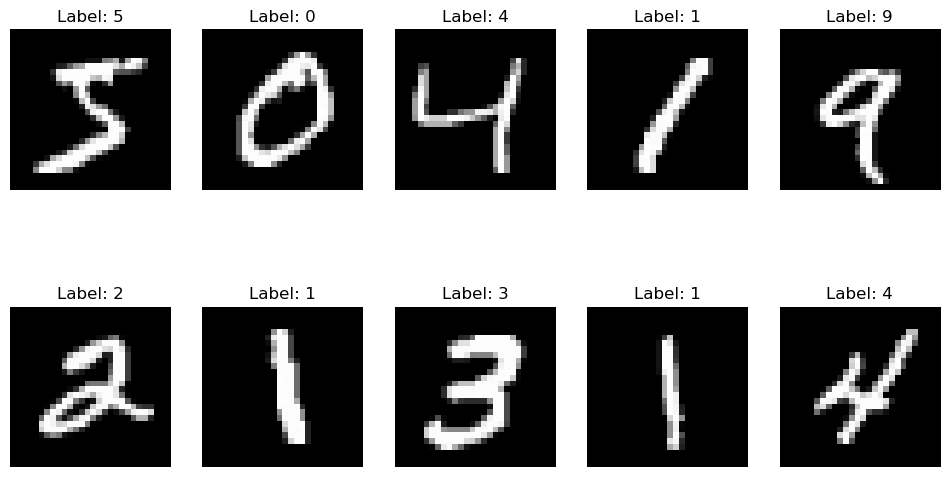

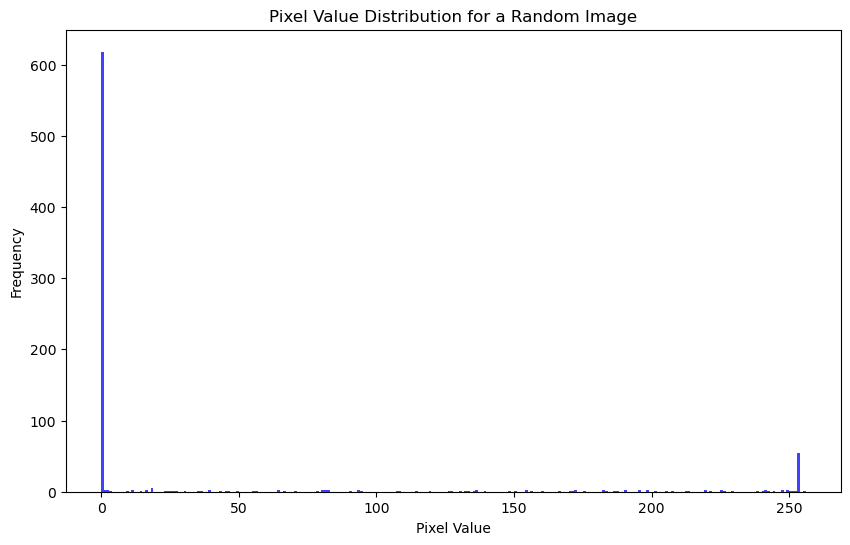

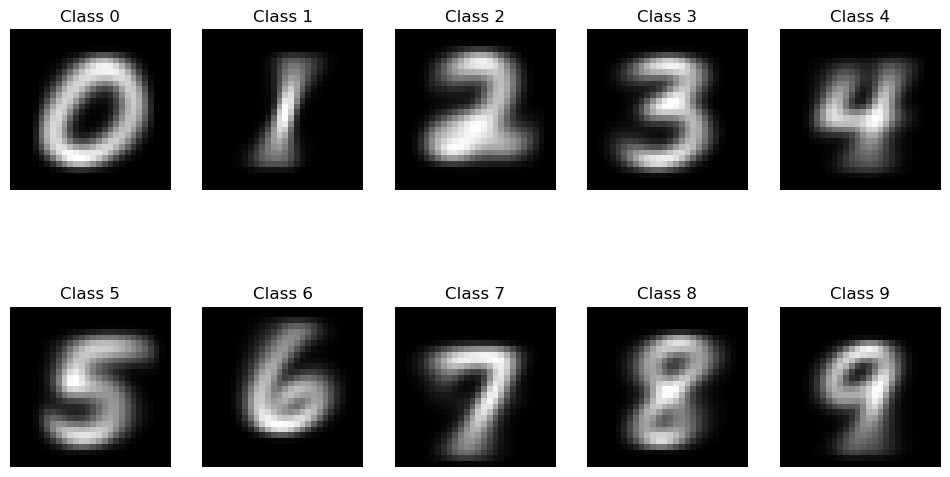

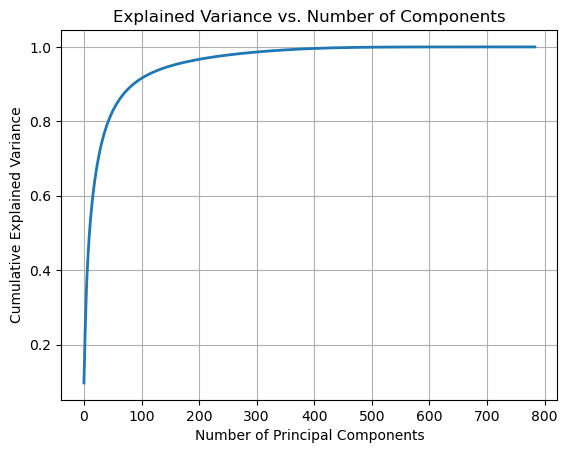

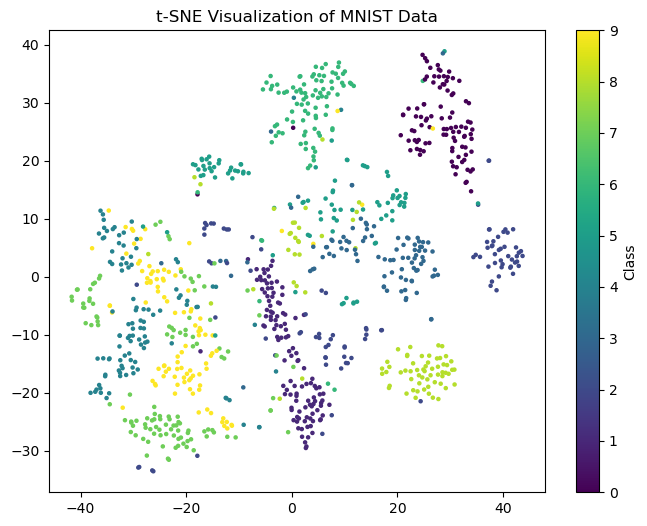

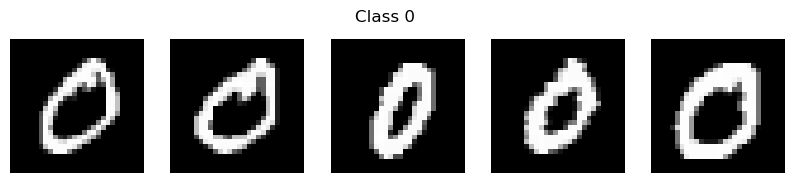

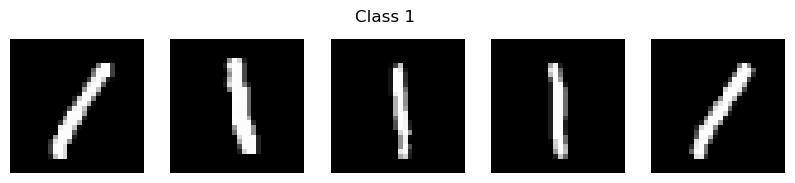

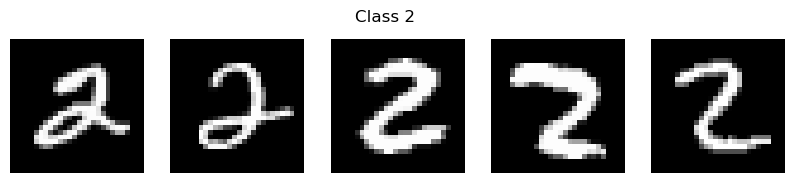

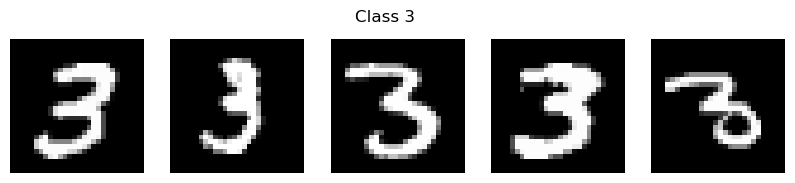

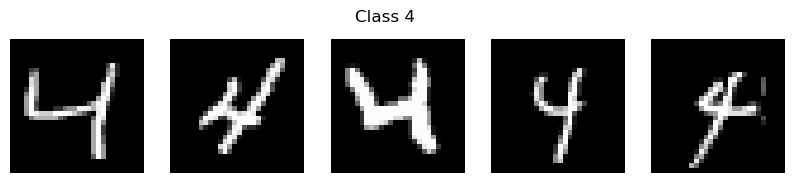

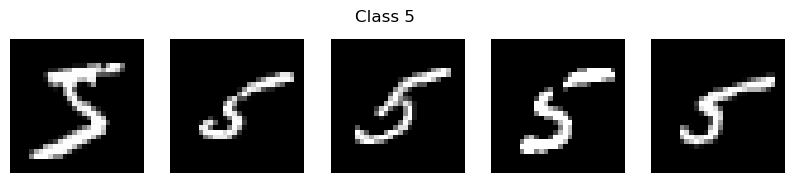

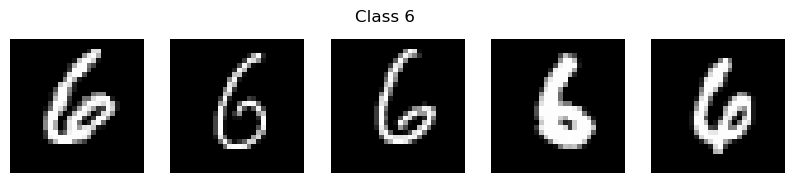

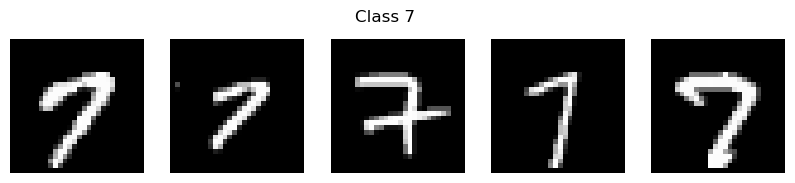

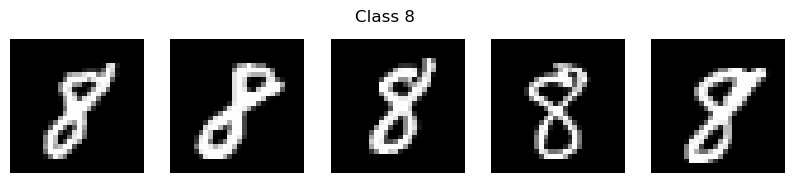

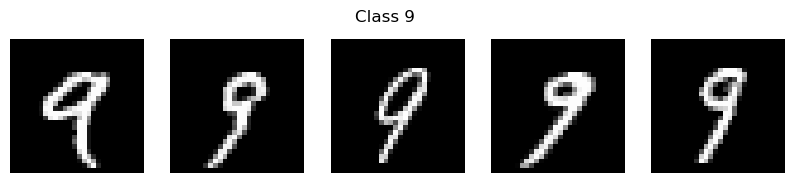

In [5]:
df_train = pd.DataFrame(X_train)
df_train['label'] = y_train


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(df_train.describe())


# Sınıf dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_train)
plt.title('Training Data Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()



# İlk 10 Görüntü ve Etiketleri
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Label: {y_train[i]}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()



# Rastgele bir görüntünün piksel değerleri histogramı
plt.figure(figsize=(10, 6))
plt.hist(X_train[0], bins=256, range=(0, 256), alpha=0.75, color='blue')
plt.title('Pixel Value Distribution for a Random Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()



# Sınıflara göre ortalama görüntüler
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    mean_image = df_train[df_train['label'] == i].iloc[:, :-1].mean().values.reshape(28, 28)
    axes[i].imshow(mean_image, cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()




# PCA'yı eğitim verilerine uygulayarak açıklanan varyansı hesaplayın
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
# Açıklanan varyansı görselleştirin
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure()
plt.plot(cumulative_explained_variance, lw=2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train[:1000])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train[:1000], cmap='viridis', s=5)
plt.title("t-SNE Visualization of MNIST Data")
plt.colorbar(scatter, label='Class')
plt.show()



for label in range(10):
    plt.figure(figsize=(10, 2))
    plt.suptitle(f"Class {label}")
    class_indices = np.where(y_train == label)[0]
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_train[class_indices[i]].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()




Veriyi analiz ederken özniteliklerin daha anlamlı hale gelmesi için boyut indirgeme (PCA) yöntemlerini uygulamanın mantıklı olacağını düşündüm. Zaten yaptığım testler sonucunda da PCA yapılmadığı zaman model eğitimi çok uzun sürede eğitildi.
Ayrıca verilerin normalizasyonu ve standartizasyonu yapılması gerekli bu da model hızını arttıracak.


# Veri ön işleme

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler


X_train = X_train / 255.0
X_test = X_test / 255.0


# Standartizasyon
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# PCA kullanarak boyut azaltma
pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


EDA'da görüldüğü üzere PCA n_component sayısını belirlemek için variance'dan yararlandım ve 200 hem başarılı bir model için hem de hızlı çalışması için yeterli olacağını gördüm.

# Logistic Regresyon Modelinin Eğitilmesi

In [7]:


lr=LogisticRegression(0.01,15,100);

In [8]:
lr.fit(X_train,y_train);

# Test Değerlerinin Tahmin Edilmesi

In [9]:
yhat = lr.predict(X_test)

# Eğitim Değerlerinin Tahmin Edilmesi

In [10]:
xhat = lr.predict(X_train)

### Tahmin Edilen Test Değerleri ile Beklenen Test Değerlerinin Karşılaştırması 

In [11]:
print("Beklenen Test Sınıfı Değerleri:")
print(list(y_test[0:100]));

print("Tahmin Değerleri:")
print(yhat[0:100]);

Beklenen Test Sınıfı Değerleri:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
Tahmin Değerleri:
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4, 1, 7, 6, 9]


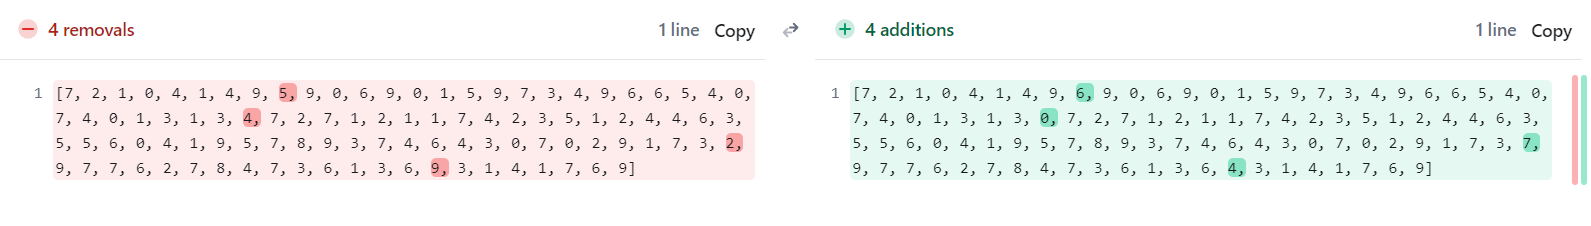
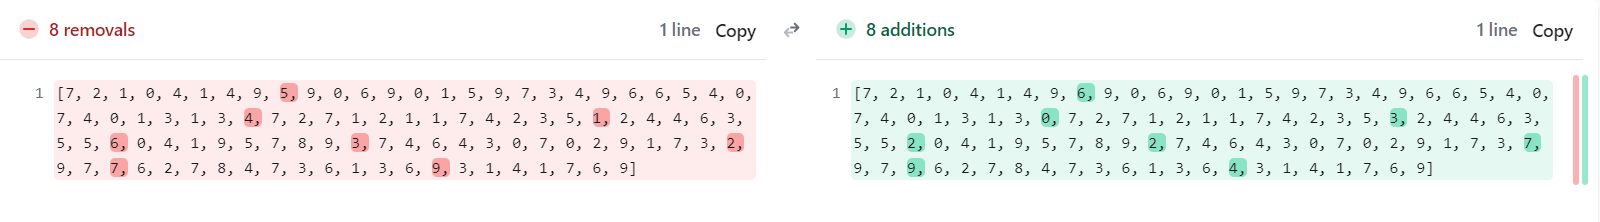

### Tahmin Edilen Eğitim Değerleri ile Beklenen Eğitim Değerlerinin Karşılaştırması 

In [12]:
print("Beklenen Eğitim Sınıfı Değerleri:")
print(list(y_train[0:600]));
print("Tahmin Değerleri:")
print(xhat[0:600]);

Beklenen Eğitim Sınıfı Değerleri:
[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3,

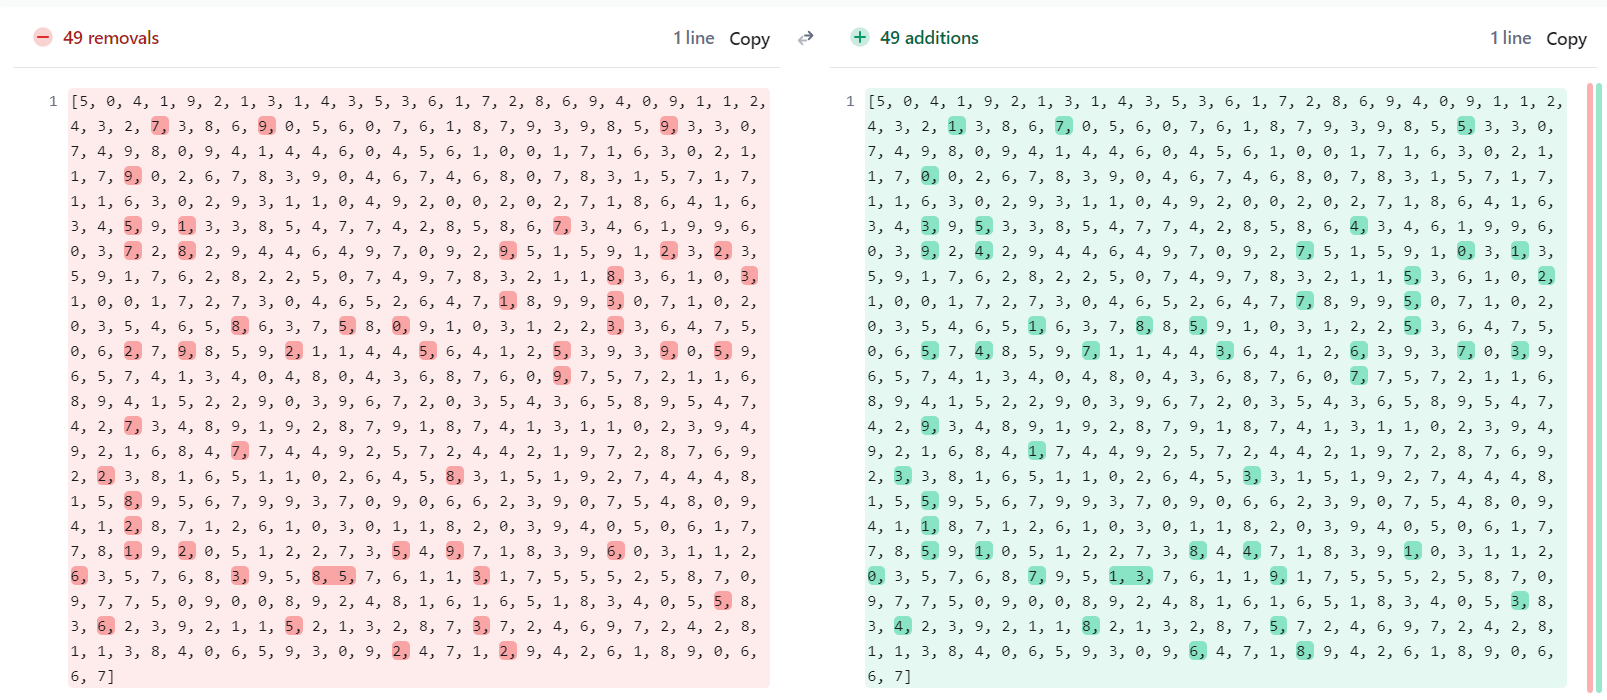
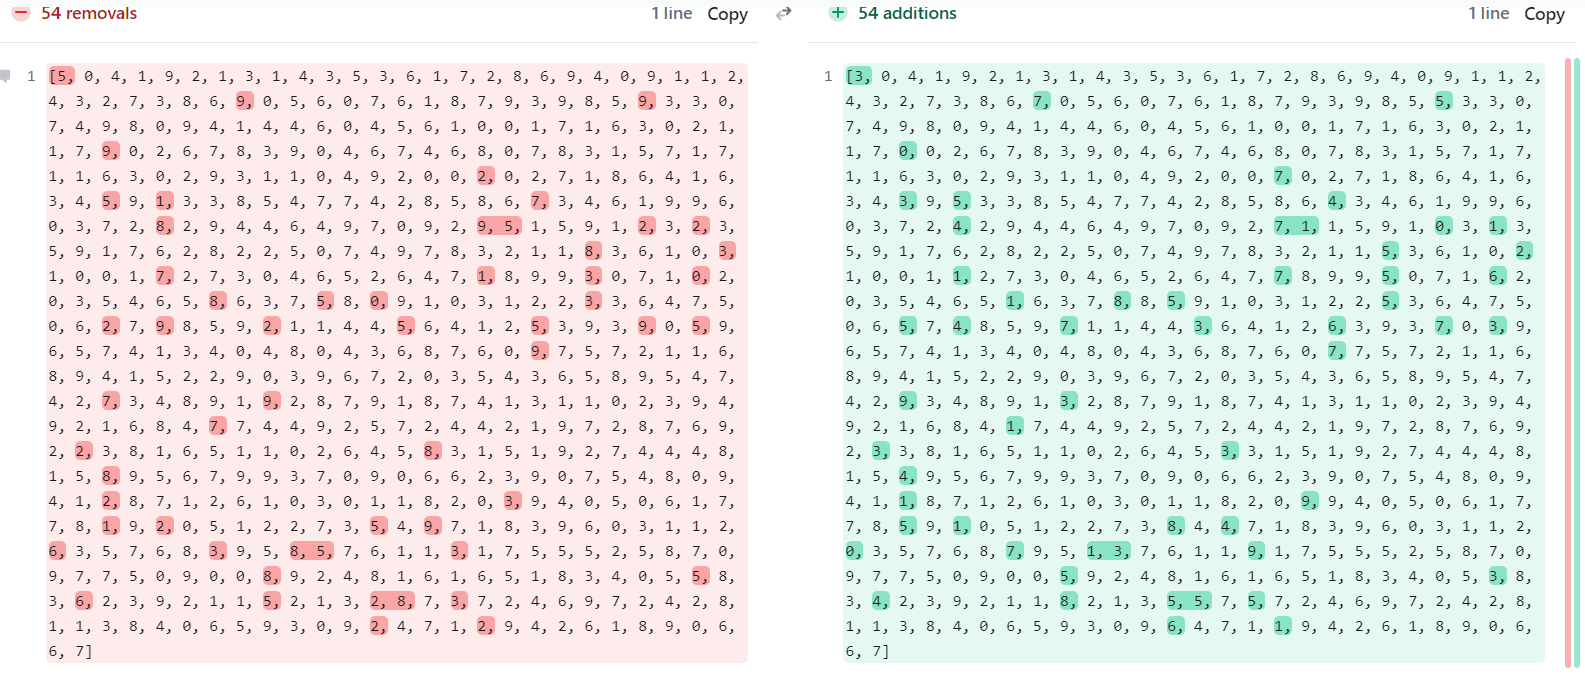

# Results

In [13]:
y_pred2 = pd.Series(yhat);
y_test2 = pd.Series(y_test);

### Test Verilerinin Confusion Matriksi 

In [14]:
conftest = confusion_matrix(y_test, yhat)
print("Test Verilerinin Confusion Matriksi:\n", conftest)

Test Verilerinin Confusion Matriksi:
 [[ 960    0    0    1    0    5    9    3    2    0]
 [   0 1107    2    2    1    1    4    2   16    0]
 [  10    8  919   20   11    3   12   13   33    3]
 [   5    1   18  916    2   26    4   14   17    7]
 [   2    5    4    0  921    1   10    3    6   30]
 [   8    4    4   32   13  770   18   11   25    7]
 [  12    4    8    1    8   12  909    2    2    0]
 [   3   12   19    8    7    0    1  947    0   31]
 [   9   15   10   20   10   32   11   13  841   13]
 [  12    8    1   12   37    6    0   25    5  903]]


Sınıf 1 için neredeyse mükemmel bir performans sergiliyor (1107 doğru tahmin, sadece 29 yanlış tahmin).
Sınıf 8 için sınıf 3 ve sınıf 5 ile karışıklık yaşanmış. Sınıf 5 ve sınıf 8, diğer sınıflara kıyasla daha fazla karışıklık yaşanan sınıflar. 

### Eğitim Verilerinin Confusion Matriksi 

In [15]:
confegitim = confusion_matrix(y_train, xhat)
print("Eğitim Verilerinin Confusion Matriksi:\n", confegitim)


Eğitim Verilerinin Confusion Matriksi:
 [[5753    3   16    9   15   40   40   13   30    4]
 [   1 6556   32   17    7   27    5   18   71    8]
 [  48   63 5362   82   82   24   68   78  129   22]
 [  29   46  128 5447   10  219   23   73  100   56]
 [  13   37   26    6 5462    8   46   19   29  196]
 [  70   40   31  158   66 4742  101   26  138   49]
 [  42   29   34    0   47   70 5660    3   32    1]
 [  17   51   64   23   62    8    3 5841   11  185]
 [  46  201   62  144   34  162   46   28 5040   88]
 [  29   29   14   81  184   41    5  185   37 5344]]


Sınıf 8 ve sınıf 3'te önemli ölçüde yanlış tahminler yapılmış. Eğitim verilerinde de bu sınıflar arasında karışıklıklar var. Ancak genel olarak oldukça performanslı şekilde çalışıyor model.

### Eğitim/Test F1-Score

In [16]:
f1_test = f1_score(y_test, yhat, average='weighted')
f1_train = f1_score(y_train, xhat, average='weighted')

print(f"Eğitim F1-Score: {f1_train}")
print(f"Test F1-Score: {f1_test}")


Eğitim F1-Score: 0.919827422903502
Test F1-Score: 0.9189681559692195


### Eğitim/Test Accuracy

In [17]:
accuracy_test = accuracy_score(y_test, yhat)
accuracy_train = accuracy_score(y_train, xhat)


print(f"Eğitim Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")


Eğitim Accuracy: 0.9201166666666667
Test Accuracy: 0.9193


### Eğitim/Test Precision

In [18]:
precision_test = precision_score(y_test, yhat, average='weighted')
precision_train = precision_score(y_train, xhat, average='weighted')


print(f"Eğitim Precision: {precision_train}")
print(f"Test Precision: {precision_test}")


Eğitim Precision: 0.9198595919681772
Test Precision: 0.9190192542921181


### Eğitim/Test Recal

In [19]:
recall_test = recall_score(y_test, yhat, average='weighted')
recall_train = recall_score(y_train, xhat, average='weighted')


print(f"Eğitim Recall: {recall_train}")
print(f"Test Recall: {recall_test}")


Eğitim Recall: 0.9201166666666667
Test Recall: 0.9193


###  ROC Eğrileri (Test/Eğitim) ve  Eğrilerin AUC Değerleri (Test/Eğitim)

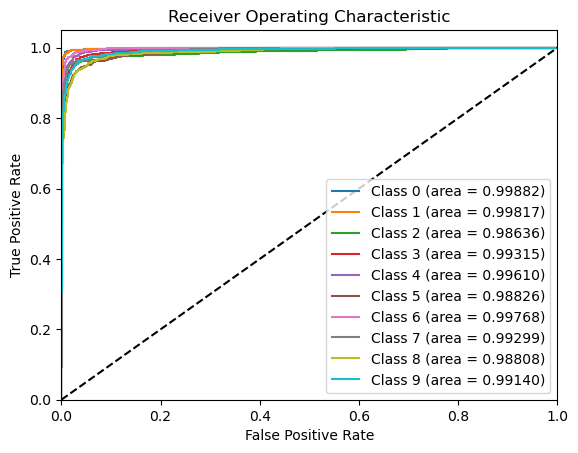

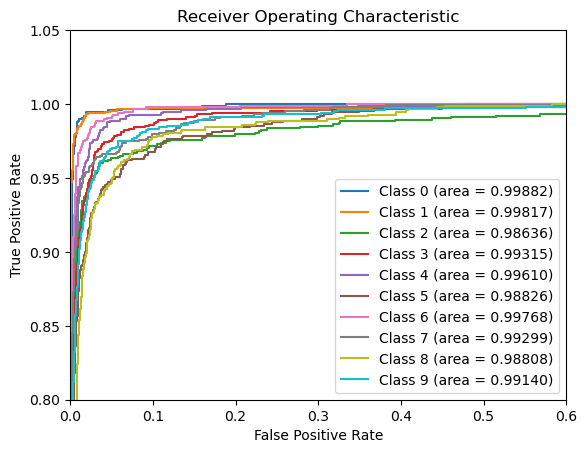

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2


# Predict probabilities
y_pred_proba = lr.predict_proba(X_test)

# Compute ROC AUC for each class
roc_auc = {}
for i in range(lr.num_classes):
    true_binary_labels = [1 if label == i else 0 for label in y_test]
    predicted_probs = [proba[i] for proba in y_pred_proba]
    roc_auc[i] = roc_auc_score(true_binary_labels, predicted_probs)

# Plot ROC curves
plt.figure()
for i in range(lr.num_classes):
    true_binary_labels = [1 if label == i else 0 for label in y_test]
    predicted_probs = [proba[i] for proba in y_pred_proba]
    fpr, tpr, _ = roc_curve(true_binary_labels, predicted_probs)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# Plot2 ROC curves
plt2.figure()
for i in range(lr.num_classes):
    true_binary_labels = [1 if label == i else 0 for label in y_test]
    predicted_probs = [proba[i] for proba in y_pred_proba]
    fpr, tpr, _ = roc_curve(true_binary_labels, predicted_probs)
    plt2.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc[i]:.5f})')
plt2.plot([0, 1], [0, 1], 'k--')
plt2.xlim([0.0, 0.6])
plt2.ylim([0.8, 1.05])
plt2.xlabel('False Positive Rate')
plt2.ylabel('True Positive Rate')
plt2.title('Receiver Operating Characteristic')
plt2.legend(loc="lower right")
plt2.show()



Accuracy, precision, recall ve F1-Score'un hepsinin 0.92 civarında olması, yaptığım modelin performansının yüksek olduğunu gösteriyor. AUC değerinin yaklaşık 0.99 çıkması ise negatif ve pozitif sınıf ayrımını kusursuza yakın şekilde yapıyor. Sınıfların farklı olduğunu anlama yeteneği yüksek. 